In [268]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
from scipy.io import loadmat

In [63]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [64]:
import sys
# Import FBP
sys.path.append('../FBPConvNet/')
from FBPConvNet import Generator, Discriminator2

sys.path.append('../')
from net_utils import get_datetime

In [65]:
from pix2pixModels import UnetGenerator,NLayerDiscriminator

# Generate Example Data

In [66]:
def preprocess(data):
    return torch.Tensor(data).unsqueeze(1)
def target_ones(N,gpu=False):
    if GPU:
        return torch.ones(N,1).cuda()
    else:
        return torch.ones(N,1)
def target_zeros(N,gpu=False):
    if GPU:
        return torch.zeros(N,1).cuda()
    else:
        return torch.zeros(N,1)   

In [6]:
# set path to data
pathtodata = '../data/RandomLineEllipses15.hdf5'
dataset_size = 200
batch_size = 1

In [7]:
f = h5py.File(pathtodata,'r')
print([ key for key in f['ellip']])
fakeinput = preprocess(f['ellip/training_data'][0:])
fakelabels = preprocess(f['ellip/training_labels'][0:])
#reallabels = preprocess(f['ellip/training_labels'][dataset_size:2*dataset_size])

testinput = preprocess(f['ellip/test_data'])
testlabels = preprocess(f['ellip/test_labels'])
f.close()

['test_data', 'test_labels', 'training_data', 'training_labels']


In [84]:
# f = h5py.File(pathtodata,'r')
# print([ key for key in f['ellip']])

# fakeinput1 = f['ellip/training_data'][0:dataset_size]
# fakeinput2 = fakeinput1.copy()[:,:,::-1]
# fakeinput = preprocess(np.concatenate((fakeinput1,fakeinput2)))

# fakelabels1 = f['ellip/training_labels'][0:dataset_size]
# fakelabels2 = fakelabels1.copy()[:,:,::-1]
# fakelabels = preprocess(np.concatenate((fakelabels1,fakelabels2)))

# reallabels1 = f['ellip/training_labels'][dataset_size:2*dataset_size]
# reallabels2 = reallabels1.copy()[:,:,::-1]
# reallabels = preprocess(np.concatenate((reallabels1,reallabels2)))

# del fakeinput1, fakeinput2, fakelabels1, fakelabels2, reallabels1, reallabels2

# # testinput = preprocess(f['ellip/test_data'])
# # testlabels = preprocess(f['ellip/test_labels'])
# f.close()

['test_data', 'test_labels', 'training_data', 'training_labels']


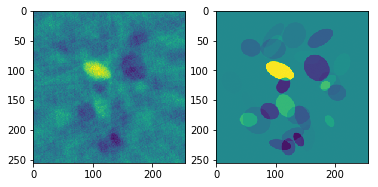

In [7]:
plt.figure()
plt.subplot(121)
plt.imshow(fakeinput[-1,0])
plt.subplot(122)
plt.imshow(fakelabels[-1,0])

In [8]:
faketrainset = TensorDataset(fakeinput,fakelabels)
testset = TensorDataset(testinput,testlabels)

faketrainloader = DataLoader(faketrainset,batch_size=batch_size,shuffle=True)
testloader = DataLoader(testset,batch_size=1,shuffle=False)

# Plot Training Loss

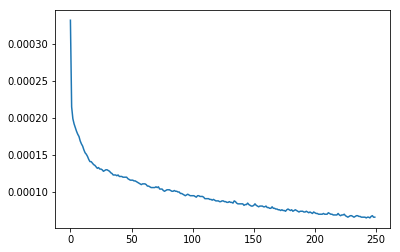

In [106]:
basepath = './experiments/UNet/'
baseloss = np.loadtxt(basepath+'log.txt',skiprows=1,usecols=(1),delimiter='\t',dtype=float)

In [99]:
# Epoch	D Loss	G Loss	Epoch Time	Total Time

In [315]:
basepath = './experiments/UNet_L2/'
da_loss = np.loadtxt(basepath+'log.txt',skiprows=1,usecols=(1), delimiter='\t' ,dtype=float)

Text(0.5,1,'Refining Loss')

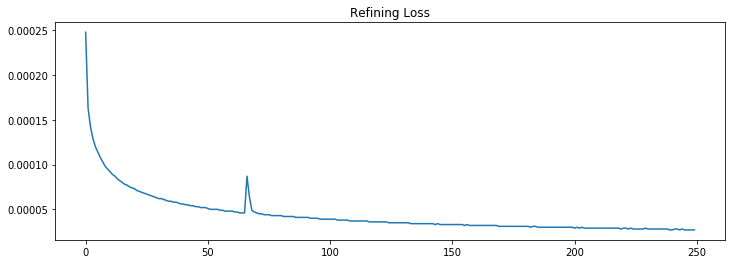

In [317]:
# totalloss = np.concatenate((baseloss,loss))
# start = 0
# end = len(totalloss)
plt.figure(figsize=(12,4))
# plt.subplot(121)
# plt.plot(np.arange(start,end),totalloss)
# plt.title('Total Loss')
# plt.subplot(122)
#plt.plot(loss,label='L1 Adam')
plt.plot(da_loss,label='Data Aug')
plt.title('Refining Loss')
#plt.legend(loc=0)

# Visualize Examples

In [196]:
def loadresults(weightspath,testloader,norm_layer=nn.BatchNorm2d):
    N = len(testloader)
    #G = Generator()
    Gbase = UnetGenerator(input_nc=1, output_nc=1, num_downs=8, ngf=64, norm_layer=norm_layer, use_dropout=True)
    GPU = torch.cuda.is_available()
    print('Using GPU:',GPU)

    checkpoint = torch.load(weightspath)
    Gbase.load_state_dict(checkpoint)
    if GPU:
        Gbase = Gbase.cuda()

    baseresults = np.zeros((N,256,256))
    basemses = np.zeros(N)
    for i,data in enumerate(testloader):
        y,x = data

        GPU = True
        if GPU:
            basexhat = Gbase(Variable(y.cuda(),volatile=True))
            basexhat = basexhat.cpu().data
        else:
            basexhat = Gbase(Variable(y)).data

        baseresults[i] = basexhat[0,0,:,:].numpy()
        # Base

        basemses[i] =torch.mean((basexhat[0,0,:,:]-x[0,0,:,:])**2)
    return baseresults,basemses



### Input/Ground Truth

In [306]:
N = len(testloader)
ys = np.zeros((N,256,256))
xs = np.zeros_like(ys)
orig_mses = np.zeros(N)

for i,data in enumerate(testloader):
    y,x = data
    ys[i] = y[0,0,...]
    xs[i] = x[0,0,...]
    orig_mses[i] = np.mean((xs[i]-ys[i])**2)
    

### L2 Norm

In [319]:
# baseGpath = './Experiments/UNet/epoch_250.weights'
# baseresults,basemses = loadresults(baseGpath,testloader)
l2_path = './Experiments/UNet_L2/epoch_250.weights'
l2_results,l2_mses = loadresults(l2_path,testloader,norm_layer=nn.InstanceNorm2d)

Using GPU: True


### L1 Norm

In [257]:
# l1_path = './Experiments/UNet_L1_Adam/epoch_250.weights'
# l1f_results,l1f_mses = loadresults(l1_path,testloader,norm_layer=nn.InstanceNorm2d)
l1_path = './Experiments/UNet_L1_DataAug/epoch_250.weights'
l1_results,l1_mses = loadresults(l1_path,testloader,norm_layer=nn.InstanceNorm2d)


Using GPU: True


### GANs + L1

In [266]:
gans_path = './Experiments/ImageGans/G_epoch_300.weights'
gans_results,gans_mses = loadresults(gans_path,testloader,norm_layer=nn.InstanceNorm2d)


Using GPU: True


### TV Reg

In [285]:
tv = loadmat('../data/tv_results')

In [311]:
TV_results = tv['recovered'].transpose(2,1,0)

tv_mses = np.array([np.mean((TV_results[i] - xs[i])**2) for i in range(100)])


### Compare

In [321]:
i=0

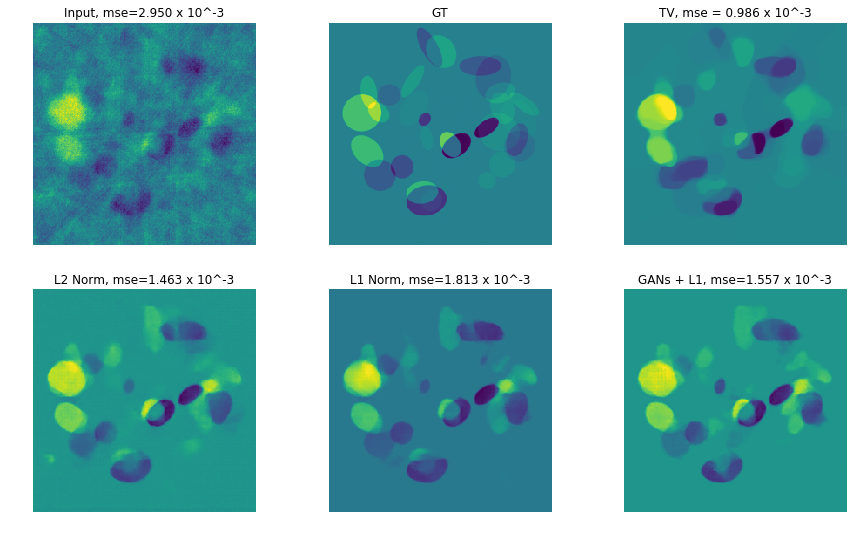

In [354]:
plt.figure(figsize=(15,9))
plt.subplot(231)
plt.imshow(ys[i])
plt.title('Input, mse=%.3f x 10^-3'%(orig_mses[i]*1000))
plt.axis('off')

plt.subplot(232)
plt.imshow(xs[i])
plt.title('GT')
plt.axis('off')

plt.subplot(233)
plt.imshow(TV_results[i])
plt.title('TV, mse = %.3f x 10^-3'%
          (tv_mses[i]*1000))
plt.axis('off')


# L2
plt.subplot(234)
plt.imshow(l2_results[i])
plt.title('L2 Norm, mse=%.3f x 10^-3'%(l2_mses[i]*1000))
plt.axis('off')

# L1
plt.subplot(235)
plt.imshow(l1_results[i])
plt.title('L1 Norm, mse=%.3f x 10^-3'%(l1_mses[i]*1000))
plt.axis('off')


plt.subplot(236)
plt.imshow(gans_results[i])
plt.title('GANs + L1, mse=%.3f x 10^-3'%(gans_mses[i]*1000))
plt.axis('off')
i+=1

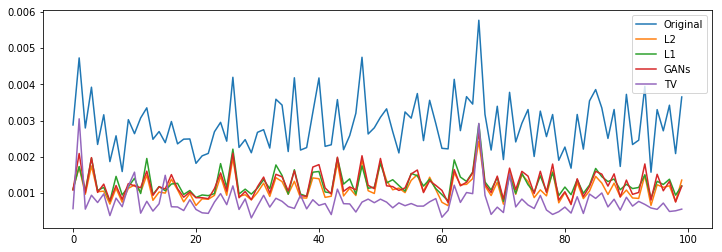

In [323]:
plt.figure(figsize=(12,4))
plt.plot(orig_mses,label='Original')
plt.plot(l2_mses,label='L2')
plt.plot(l1_mses,label='L1')
plt.plot(gans_mses,label='GANs')
plt.plot(tv_mses,label='TV')
plt.legend(loc=0)

In [341]:
temp = Variable(torch.rand(5,1,5,5))
temp2 = torch.ones_like(temp)
print(temp,temp2)
#print(nn.BCELoss()(Variable(temp),Variable(temp2)))

Variable containing:
(0 ,0 ,.,.) = 
  0.1406  0.4273  0.5165  0.3656  0.7101
  0.5470  0.6398  0.6719  0.9402  0.5352
  0.5149  0.0572  0.9582  0.5398  0.8165
  0.7807  0.0146  0.0772  0.5770  0.7469
  0.1496  0.9735  0.2205  0.9573  0.8679

(1 ,0 ,.,.) = 
  0.1193  0.0641  0.4388  0.9117  0.2065
  0.3887  0.9978  0.7747  0.1541  0.3942
  0.0577  0.0194  0.4058  0.9831  0.1679
  0.0920  0.4970  0.6589  0.7258  0.9222
  0.0666  0.2342  0.8795  0.6202  0.3421

(2 ,0 ,.,.) = 
  0.3569  0.3588  0.5188  0.9233  0.7657
  0.9796  0.3572  0.3299  0.9028  0.7363
  0.0028  0.5983  0.4030  0.2500  0.0243
  0.0463  0.2813  0.3313  0.7870  0.7044
  0.7915  0.6344  0.2709  0.6739  0.2153

(3 ,0 ,.,.) = 
  0.0098  0.1932  0.4053  0.0351  0.3527
  0.4930  0.1807  0.5921  0.8143  0.7407
  0.9615  0.2553  0.1751  0.3039  0.8986
  0.2765  0.5947  0.6454  0.1252  0.5812
  0.8069  0.0410  0.4839  0.8685  0.6276

(4 ,0 ,.,.) = 
  0.7041  0.8209  0.0045  0.6934  0.5640
  0.1358  0.4390  0.5352  0.5369  0.018

# Compute Average MSE

In [93]:
def test_mse(G, testloader):
    # Calculate Test MSE
    test_mses = np.zeros(len(testloader))
    for i,data in enumerate(testloader):
        y,x = data 
        GPU = True
        if GPU:
            xhat = G(Variable(y.cuda(),volatile=True))
            xhat = xhat.cpu().data
        else:
            xhat = G(Variable(y,volatile=True)).data

        test_mses[i] = torch.mean((xhat[:,0,:,:]-x[:,0,:,:])**2)
    return test_mses.mean()

In [94]:
mse = test_mse(G,testloader)
print('Test MSE = %f'%(mse))

Test MSE = 0.001723


In [95]:
nums = range(0,250,25)
len(nums), nums[-1]

(10, 225)

In [263]:
mses = np.zeros(len(nums)+1)
train_mses = np.zeros(len(nums)+1)

G = UnetGenerator(input_nc=1, output_nc=1, num_downs=8, ngf=64, norm_layer=nn.InstanceNorm2d, use_dropout=True)
basepath = './experiments/Unet_L1_DataAug/'
G_basepath = basepath + 'epoch_'
last = 250
for i,epoch in enumerate(nums):
    weightspath = G_basepath + str(epoch+1) + '.weights'
    checkpoint = torch.load(weightspath)
    G.load_state_dict(checkpoint)
    G = G.cuda()
    mses[i] = test_mse(G,testloader)
    train_mses[i] = test_mse(G,faketrainloader)

weightspath = G_basepath + str(last) + '.weights'
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)
G = G.cuda()
mses[-1] = test_mse(G,testloader)
train_mses[-1] = test_mse(G,faketrainloader)


Test: 0.0012722256376970706 0.0011205028646293382
Train: 0.0008090469783066194 0.0007138415626433378


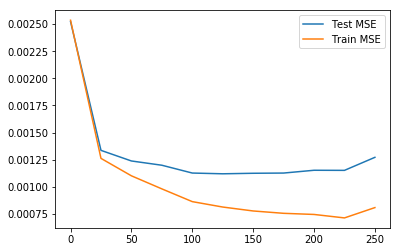

In [264]:
plt.figure()
#plt.plot(nums,mses)
epochs = range(0,last+1,25)
plt.plot(epochs,mses,label='Test MSE')
plt.plot(epochs,train_mses,label='Train MSE')
plt.legend(loc=0)

print('Test:',mses[-1],mses.min())
print('Train:',train_mses[-1],train_mses.min())

# Test Discriminator

In [48]:
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        # Input 1 x 256 x 256 -> 64 x 128 x 128
        self.conv1 = nn.Conv2d(1,64,3,padding=1,stride=2)
        self.batch1 = nn.BatchNorm2d(64)

        # -> 128 x 64 x 64
        self.conv2 = nn.Conv2d(64,128,7,padding=3,stride=2)
        self.batch2 = nn.BatchNorm2d(128)

        # -> 256 x 32 x 32 -> 256 x 16 x 16
        self.conv3 = nn.Conv2d(128,256,5,padding=2,stride=2)
        self.batch3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,256,7,padding=3,stride=2)
        self.batch4 = nn.BatchNorm2d(256)

        # -> 512 x 8 x 8
        self.conv5 = nn.Conv2d(256,512,5,padding=2,stride=2)
        self.batch5 = nn.BatchNorm2d(512)

        # -> 1024 x 1 x 1
        self.conv6 = nn.Conv2d(512,1024,5,padding=2,stride=2)
        self.batch6 = nn.BatchNorm2d(1024)
        self.conv7 = nn.Conv2d(1024,1024,3,padding=1,stride=2)
        self.batch7 = nn.BatchNorm2d(1024)

        self.conv8 = nn.Conv2d(1024,1024,3,padding=1,stride=2)
        self.batch8 = nn.BatchNorm2d(1024)

        self.conv9 = nn.Conv2d(1024,1024,3,padding=1,stride=2)

        # Decision layers
        self.d_conv1 = nn.Conv2d(1024,1024,2)
#         self.d_conv2 = nn.Conv2d(1024,1024,1)
        self.d_conv3 = nn.Conv2d(1024,1,1)

        # Non-Linear Activations
        self.leaky = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv2_drop = nn.Dropout2d(p=.2)
  
    def forward(self,x):
        # Generate Features
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.batch2(self.conv2(x)))
        x = self.leaky(self.batch3(self.conv3(x)))
        x = self.leaky(self.batch4(self.conv4(x)))
        x = self.leaky(self.batch5(self.conv5(x)))
        x = self.leaky(self.batch6(self.conv6(x)))
        x = self.leaky(self.batch7(self.conv7(x)))
        #x = self.leaky(self.batch8(self.conv8(x)))
        #x = self.leaky(self.conv9(x))

        # Decision Layers
        x = self.leaky(self.conv2_drop(self.d_conv1(x)))
        x = self.sigmoid(self.d_conv3(x))
        return x


In [121]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=1024, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*8*8, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*8*8)
        x = self.out(x)
        return x

In [122]:
def test_D_accuracy(D, faketrainloader, realtrainloader,GPU=True):
    # assumes batchsize 1 for now
    flen = len(faketrainloader)
    rlen = len(realtrainloader)
    gt = np.zeros(flen+rlen)
    gt[flen:] = 1
    
    predictions = np.zeros(flen + rlen)
    for i,data in enumerate(faketrainloader):
        input_, label = data
        input_ = input_.cuda()
        pred = D(G(Variable(input_,volatile=True)))
        predictions[i] = pred.data

    for i,input_ in enumerate(realtrainloader,flen):
        input_ = input_.cuda()
        pred = D(Variable(input_,volatile=True))
        predictions[i] = pred.data
        
    final = predictions.copy()
    final[final < .5] = 0
    final[final > .5] = 1

    return np.sum(np.abs(final - gt))/(rlen+flen), predictions



In [28]:
dpath = basepath + 'D_epoch_250.weights'
D = NLayerDiscriminator(1)
checkpoint = torch.load(dpath)
D.load_state_dict(checkpoint)
GPU = True

In [29]:
if GPU:
    D = D.cuda()

In [65]:
nums = range(0,500,25)
d_accuracy = np.zeros(len(nums)+1)

D_basepath = basepath + 'D_epoch_'

for i,epoch in enumerate(nums):
    weightspath = D_basepath + str(epoch+1) + '.weights'
    checkpoint = torch.load(weightspath)
    D.load_state_dict(checkpoint)
    D = D.cuda()
    acc,pred = test_D_accuracy(D,faketrainloader,realtrainloader)
    d_accuracy[i] = acc

weightspath = D_basepath + str(500) + '.weights'
checkpoint = torch.load(weightspath)
D.load_state_dict(checkpoint)
D = D.cuda()
acc,pred = test_D_accuracy(D,faketrainloader,realtrainloader)
d_accuracy[-1] = acc

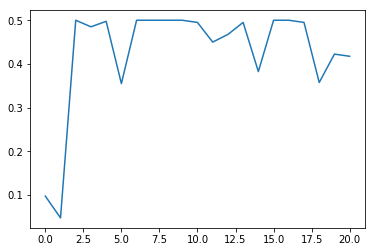

In [66]:
plt.plot(d_accuracy)

In [51]:
dpath = basepath + 'D_epoch_26.weights'
D = NLayerDiscriminator(1,use_sigmoid=True)
checkpoint = torch.load(dpath)
D.load_state_dict(checkpoint)
D = D.cuda()

In [52]:
gt = np.zeros(400)
gt[200:] = 1

In [53]:
predictions = np.zeros(400)
for i,data in enumerate(faketrainloader):
    input_, label = data
    input_ = input_.cuda()
    pred = D(G(Variable(input_,volatile=True)))
    predictions[i] = pred.data
    
for i,input_ in enumerate(realtrainloader,200):
    input_ = input_.cuda()
    pred = D(Variable(input_,volatile=True))
    predictions[i] = pred.data
    


0.52


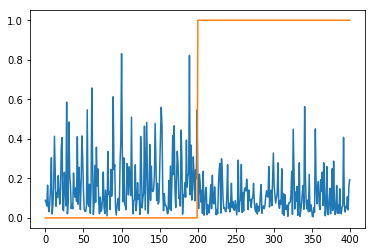

In [55]:
final = predictions.copy()
final[final < .5] = 0
final[final > .5] = 1
plt.plot(predictions)
plt.plot(gt)
#plt.plot(final)
print(np.sum(np.abs(final - gt))/400)

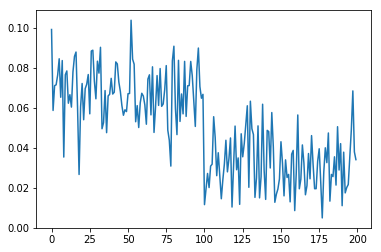

In [39]:
test_predictions = np.zeros(2*len(testloader))
for i,data in enumerate(testloader):
    input_, label = data
    input_ = input_.cuda()
    pred = D(G(Variable(input_,volatile=True)))
    test_predictions[i] = pred.data
    
    label = label.cuda()
    pred = D(Variable(label,volatile=True))
    test_predictions[i+len(testloader)] = pred.data

plt.figure()
plt.plot(test_predictions)

# Ignore 

In [170]:
def convblock(in_channels, out_channels, use_batch=False):
    model = [nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=4, 
            stride=2, padding=1, bias=False
        )]
    if use_batch:
        model += [nn.BatchNorm2d(out_channels)]
    model += [nn.LeakyReLU(0.2, inplace=True)]
    return nn.Sequential(*model)
def deconvblock(in_channels, out_channels,use_dropout=False, use_batch=False):
    model = [nn.ConvTranspose2d(in_channels, out_channels,
                                        kernel_size=4, stride=2,
                                        padding=1)]
    if use_batch:
        model += [nn.BatchNorm2d(out_channels)]
    if use_dropout:
        model += [nn.Dropout(.5)]
    model += [nn.ReLU(inplace=True)]
    return nn.Sequential(*model)
    
    
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator,self).__init__()
        # encoder
        use_batch = True
        self.conv1 = convblock(1,64)
        self.conv2 = convblock(64,128,use_batch)
        self.conv3 = convblock(128,256,use_batch)
        self.conv4 = convblock(256,512,use_batch)
        self.conv5 = convblock(512,512,use_batch)
        self.conv6 = convblock(512,512,use_batch)
        self.conv7 = convblock(512,512,use_batch)
        self.conv8 = convblock(512,512)
        # decoder
        use_dropout = True
        

        # decoder
        self.deconv1 = deconvblock(512,512,use_dropout=use_dropout)
        self.deconv2 = deconvblock(1024,512,use_dropout=use_dropout,use_batch=use_batch)
        self.deconv3 = deconvblock(1024,512,use_dropout=use_dropout,use_batch=use_batch)
        self.deconv4 = deconvblock(1024,512,use_dropout=use_dropout,use_batch=use_batch)
        self.deconv5 = deconvblock(512,512,use_batch=use_batch)
        #self.deconv6 = deconvblock(512,256,use_batch=use_batch)

        
        #self.model = nn.Sequential(*model)
        
        
    def forward(self,x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)
        
        dx1 = self.deconv1(x8)
        dx2 = self.deconv2(torch.cat([dx1,x7],1))
        dx3 = self.deconv3(torch.cat([dx2,x6],1))
        dx4 = self.deconv4(torch.cat([dx3,x5],1))
        #dx5 = self.deconv5(torch.cat([dx4,x4],1))
        print(dx4.size(),x4.size())

        return dx4

In [177]:
# Defines the Unet generator.
# |num_downs|: number of downsamplings in UNet. For example,
# if |num_downs| == 7, image of size 128x128 will become of size 1x1
# at the bottleneck
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        for i in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)

        self.model = unet_block

    def forward(self, input):
        return self.model(input)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost

        use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [178]:
net = UnetGenerator(input_nc=1, output_nc=1, num_downs=8, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=True)
net(Variable(torch.rand(4,1,256,256))).size()

torch.Size([4, 1, 256, 256])

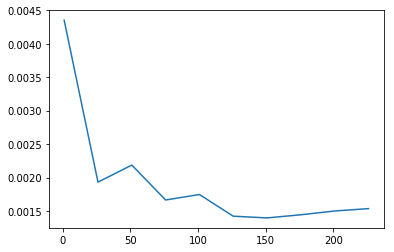

In [135]:
plt.plot(np.arange(1,227,25),mses)

In [96]:
print(mses[-1], mses.min())

0.0015492109404315864 0.001338506935090303


In [97]:
test_mses = np.zeros(len(testloader))

for i,data in enumerate(testloader):
    y,x = data 

    test_mses[i] = torch.mean((y[:,0,:,:]-x[:,0,:,:])**2)
print(test_mses.mean())

0.002872662238750937


In [ ]:
G = G.cpu()
torch.save(G.state_dict(),'Gmse_100.weights')
D = D.cpu()
torch.save(D.state_dict(),'Dmse_100.weights')

if GPU:
    G = G.cuda()
    D = D.cuda()
